In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [60]:
VERBOSE = 0
N_JOBS = 6

# Evaluation

Article Source: A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data 
Goldstein M, Uchida S (2016) A Comparative Evaluation of Unsupervised Anomaly Detection Algorithms for Multivariate Data. PLOS ONE 11(4): e0152173. https://doi.org/10.1371/journal.pone.0152173

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OPQMVF

I'm going to test the following dataset:
1. Pen-Global
1. Pen-Local
1. Speech
1. Aloi

On the following metrics: ROC-AUC

## Pen-Global Dataset

Paper version: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/OPQMVF/KQYDN9&version=1.0

Original UCI: https://archive.ics.uci.edu/ml/datasets/Pen-Based%20Recognition%20of%20Handwritten%20Digits

In [61]:
def plot_datapoint(datapoint):
    xs = []
    ys = []

    for i, v in enumerate(datapoint):
        if i % 2 == 0:
            xs.append(v)
        else:
            ys.append(v)

    plt.plot(xs, ys)
    plt.show()

In [62]:
input_names = []

for i in range(8):
    input_names.append(f'x{i}')
    input_names.append(f'y{i}')

data = pd.read_csv('/Users/maxfrax/Downloads/pen-global-unsupervised-ad.csv', names=input_names+['outlier'])
data = data.sample(frac=1)

In [63]:
data

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,outlier
117,9.0,32.0,60.0,62.0,80.0,100.0,6.0,93.0,36.0,56.0,100.0,27.0,57.0,0.0,0.0,25.0,n
744,24.0,49.0,98.0,70.0,100.0,100.0,49.0,74.0,84.0,35.0,69.0,0.0,0.0,18.0,69.0,45.0,n
207,54.0,63.0,100.0,76.0,80.0,100.0,43.0,75.0,51.0,35.0,47.0,0.0,0.0,16.0,27.0,46.0,n
100,0.0,79.0,51.0,59.0,100.0,29.0,51.0,0.0,22.0,26.0,51.0,60.0,73.0,94.0,9.0,100.0,n
667,52.0,95.0,0.0,83.0,42.0,41.0,81.0,0.0,1.0,2.0,44.0,39.0,100.0,75.0,50.0,100.0,n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,54.0,83.0,11.0,68.0,44.0,32.0,30.0,0.0,0.0,27.0,49.0,59.0,100.0,90.0,21.0,100.0,n
38,64.0,93.0,0.0,67.0,97.0,67.0,89.0,100.0,14.0,70.0,100.0,68.0,96.0,36.0,28.0,0.0,o
773,90.0,52.0,79.0,100.0,0.0,99.0,19.0,50.0,66.0,4.0,16.0,0.0,34.0,51.0,100.0,86.0,n
526,67.0,96.0,20.0,100.0,21.0,59.0,41.0,20.0,11.0,0.0,0.0,35.0,48.0,65.0,100.0,93.0,n


In [64]:
X = data[input_names]
y = data['outlier'] == 'o'

y = [-1 if v else 1 for v in y]

### Normalization

In the paper the declare they scale all their datasets with MinMax (Normalization section)

In [65]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns=input_names)

Let's plot the first number to show we understood the dataset correctly. As we can see the plot shows the number 8, which is expected since the normal class is just the number 8.

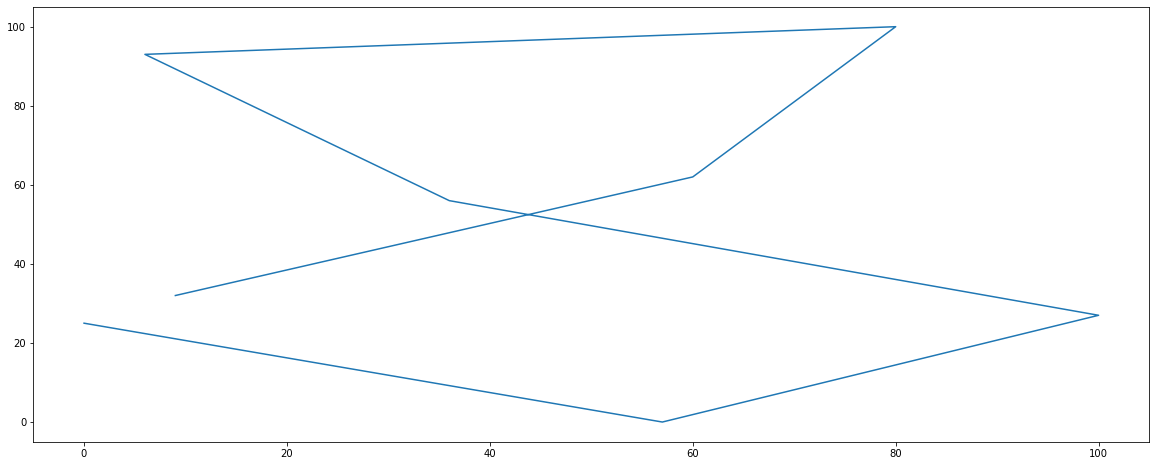

117    n
Name: outlier, dtype: object

In [66]:
plot_datapoint(data[input_names][0:1].values[0])
data[0:1]['outlier']

Plot with scaling applied:

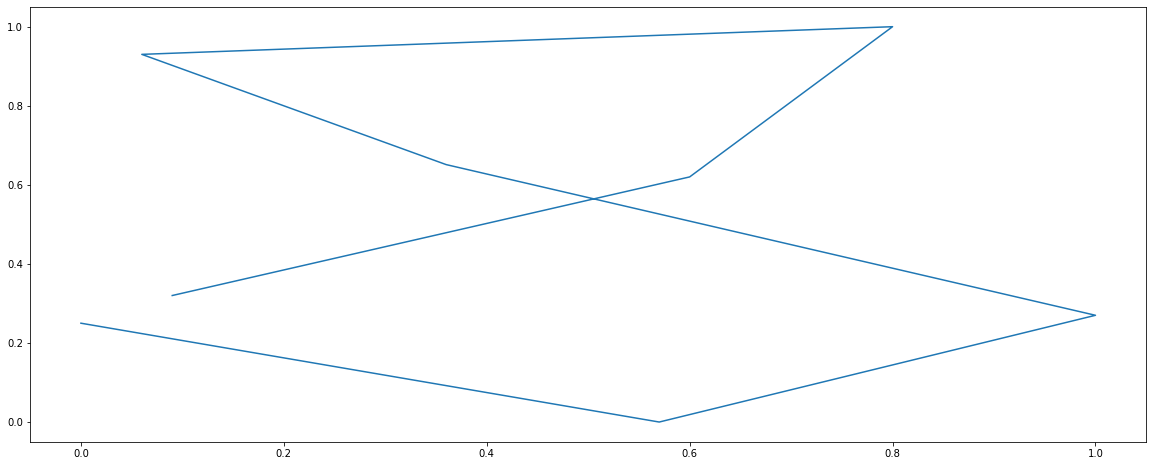

117    n
Name: outlier, dtype: object

In [67]:
plot_datapoint(X[0:1].values[0])
data[0:1]['outlier']

In [68]:
plt.rcParams["figure.figsize"] = (20, 8)

### Replicating: One Class SVM

I'm going to use sklearn implementation https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html since both the paper and sklearn refer to:

Estimating the support of a high-dimensional distribution Schölkopf, Bernhard, et al. Neural computation 13.7 (2001): 1443-1471.

In the paper they use OneClassSVM in an unsupervised setting.

> In the unsupervised anomaly detection scenario, the one-class SVM is trained using the dataset and afterwards, each instance in the dataset is scored by a normalized distance to the determined decision boundary [40]. The parameter ν needs to be set to a value lager than zero such that the contained anomalies are correctly handled by a soft-margin

The hyper parameters tested are 0.2 < v < 0.8 and automatic tuning for the Gaussian kernel.
By automatic tuning I guess they talk about trial and error. In fact they declare it as a computationally hard task.

In [69]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [70]:
def svm_experiment(classifier, distributions, metric: str):
    print(f'One Class Experiment: {metric}')

    # Gamma is a free parameter. It ranges from 0 to infinity
    # Predefined split to train on the whole dataset and test on the whole dataset
    test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

    search = RandomizedSearchCV(classifier, distributions, cv=PredefinedSplit(test_fold=test_fold), refit=True, n_iter=100, scoring='average_precision', n_jobs=N_JOBS, error_score='raise', verbose=VERBOSE)

    res = search.fit(pd.concat([X,X]).to_numpy(), y+y)

    clf = res.best_estimator_

    print(res.best_index_)
    print(res.best_score_)
    print(res.best_params_)


    y_pred = clf.predict(X.to_numpy())

    conf_mat = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(conf_mat).plot()
    plt.show()

    display(conf_mat)

    RocCurveDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

    plt.show()

    PrecisionRecallDisplay.from_predictions(y, clf.score_samples(X.to_numpy()))

    plt.show()

    cv_results = pd.DataFrame(res.cv_results_)
    cv_results.sort_values('rank_test_score')

    print(f"Average Score: {np.average(cv_results['mean_test_score'])}")
    print(f"STD Score: {np.std(cv_results['mean_test_score'])}")

One Class Experiment: roc_auc
84
0.9983332047580623
{'gamma': 2.822883405195023, 'nu': 0.8502257843924501}


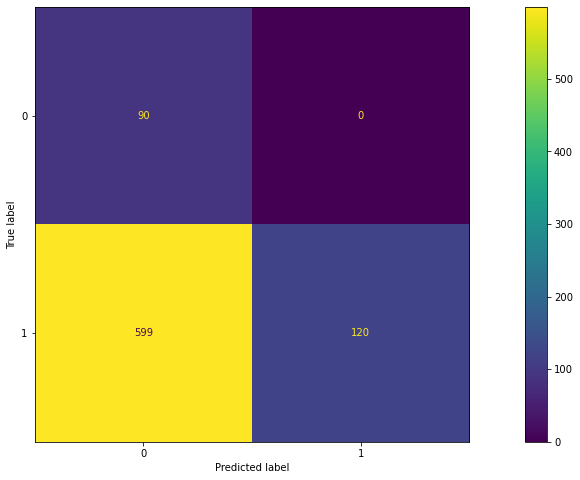

array([[ 90,   0],
       [599, 120]])

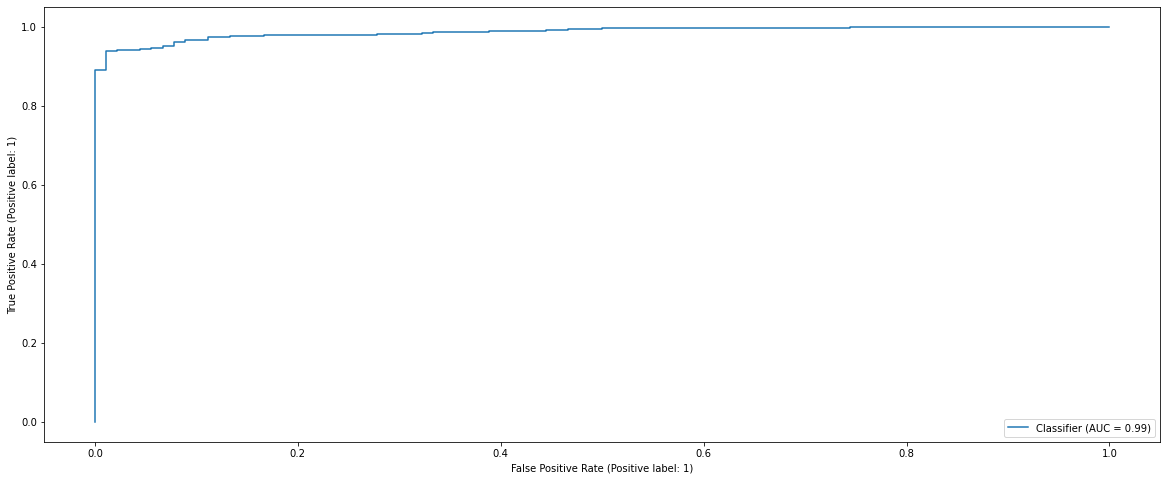

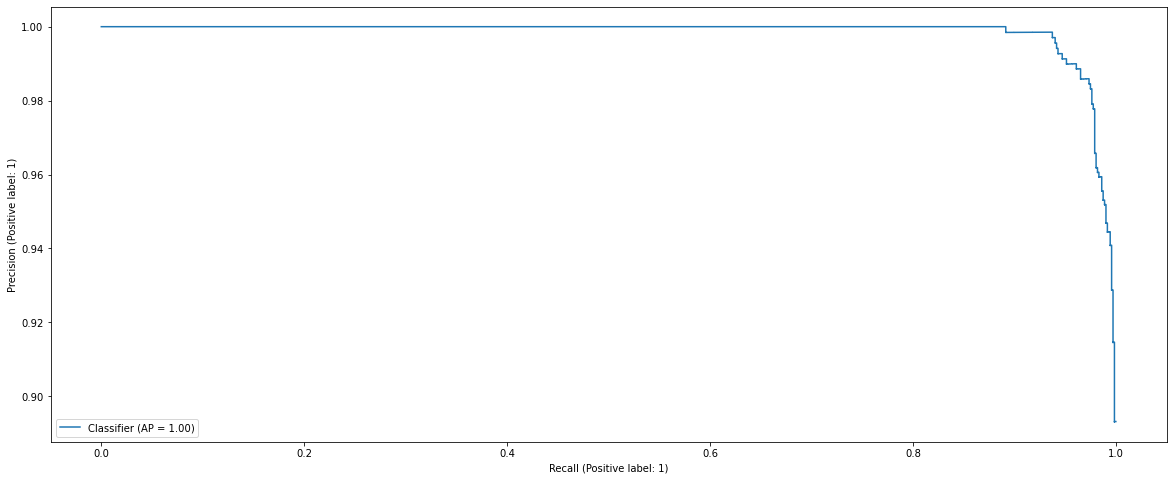

Average Score: 0.9901864315961612
STD Score: 0.008804146776287599
One Class Experiment: average_precision
88
0.9983397072187448
{'gamma': 2.866731217441584, 'nu': 0.8556885755352905}


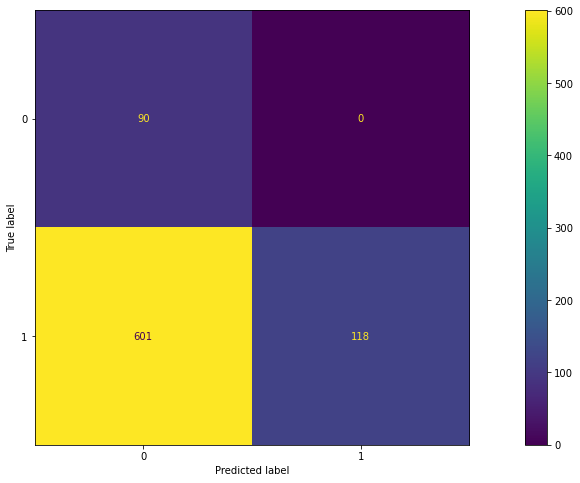

array([[ 90,   0],
       [601, 118]])

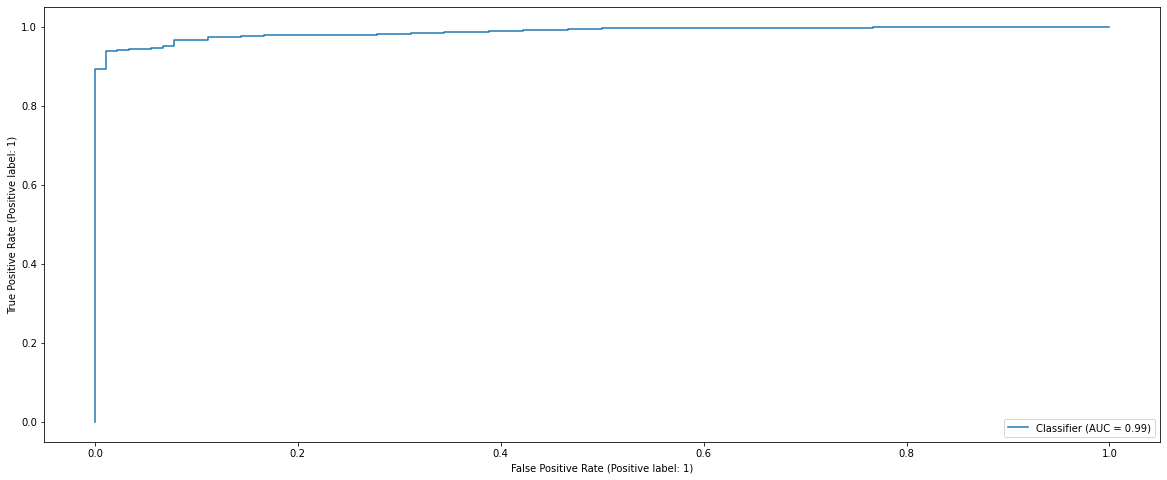

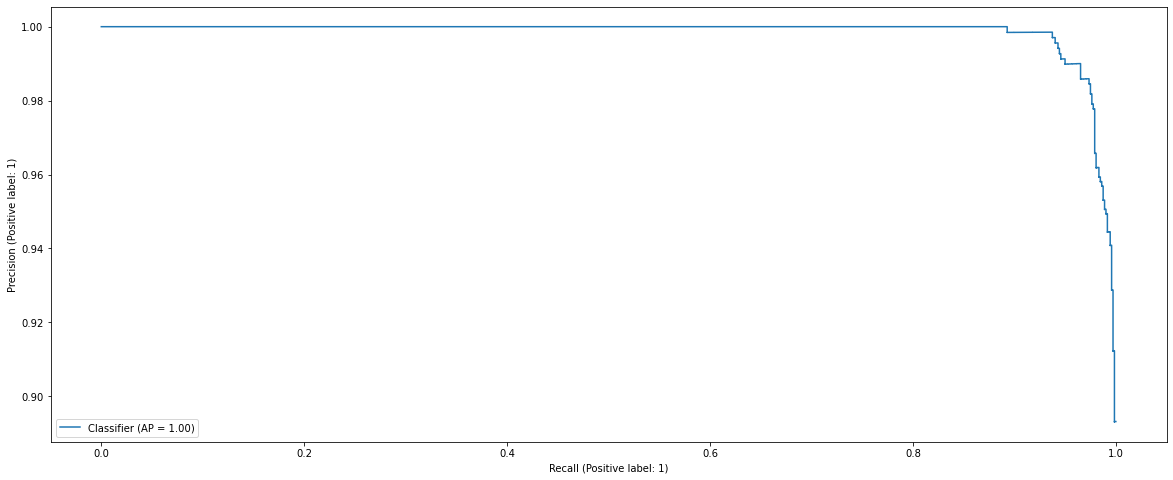

Average Score: 0.9886088504227627
STD Score: 0.010954227664458508


In [71]:
classifier = OneClassSVM(kernel='rbf')
distributions = dict(nu=uniform(loc=0.2, scale=0.8), gamma=uniform(loc=0, scale=3))

svm_experiment(classifier, distributions, 'roc_auc')
svm_experiment(classifier, distributions, 'average_precision')

### My Algorithm: BSVClassifier

In [72]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.bsvclassifier import BSVClassifier

One Class Experiment: roc_auc
1
1.0
{'c': 0.8001671339354661, 'q': 2.8665045423916373}


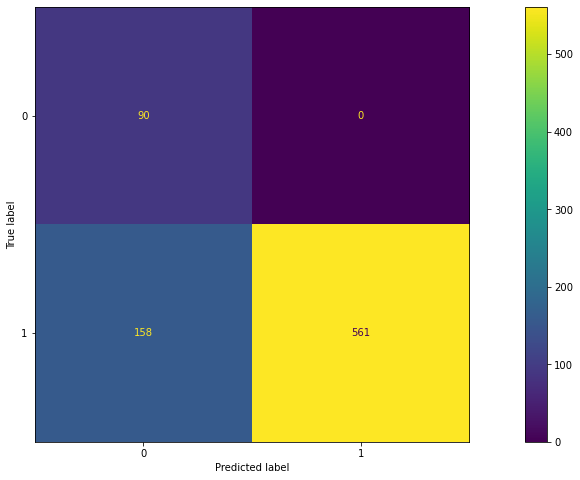

array([[ 90,   0],
       [158, 561]])

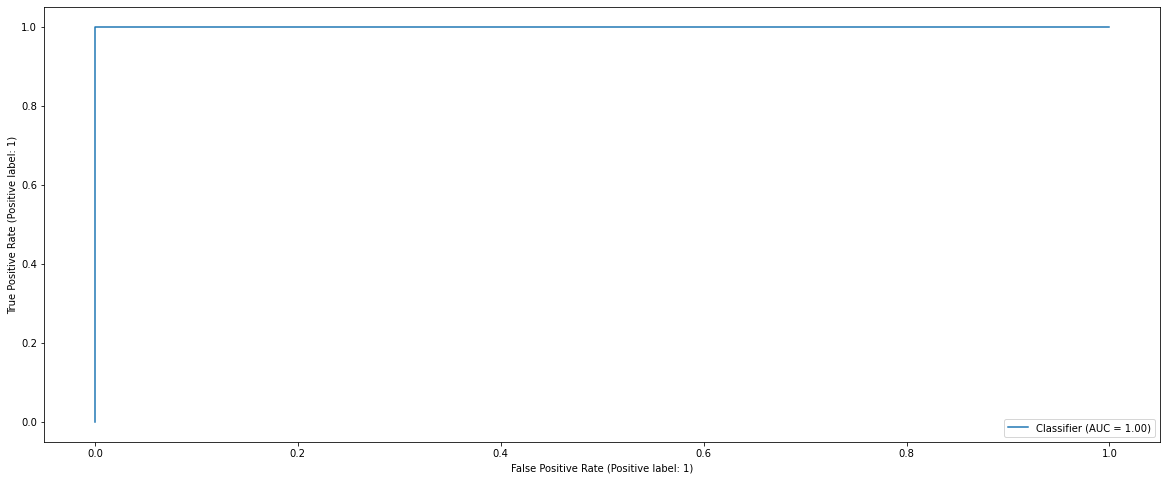

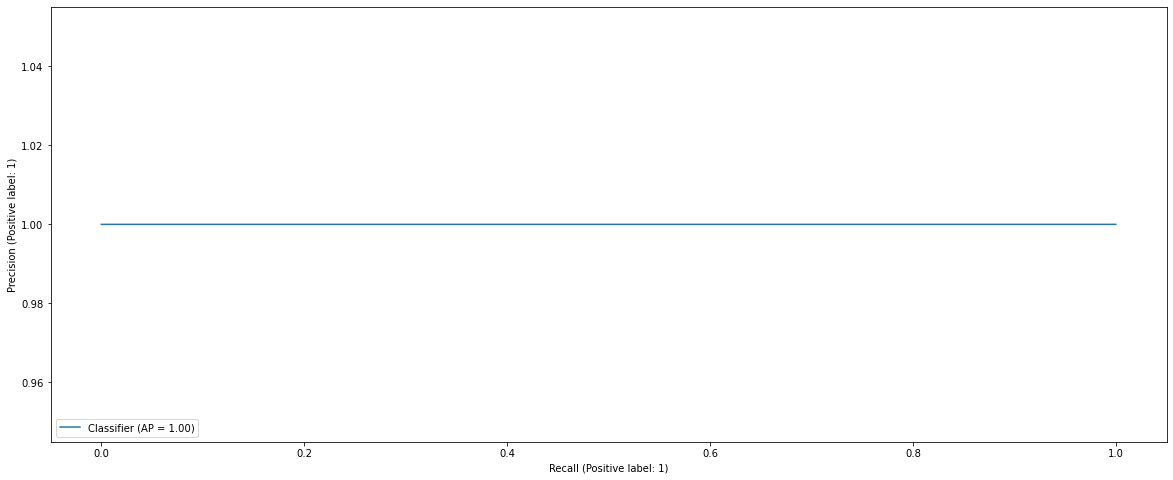

Average Score: 0.9975915879261362
STD Score: 0.007403186241160767
One Class Experiment: average_precision
2
1.0
{'c': 0.7444500057198533, 'q': 2.5765395827289863}


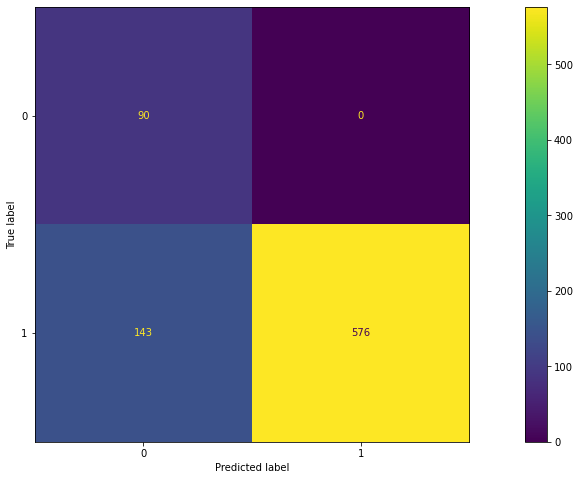

array([[ 90,   0],
       [143, 576]])

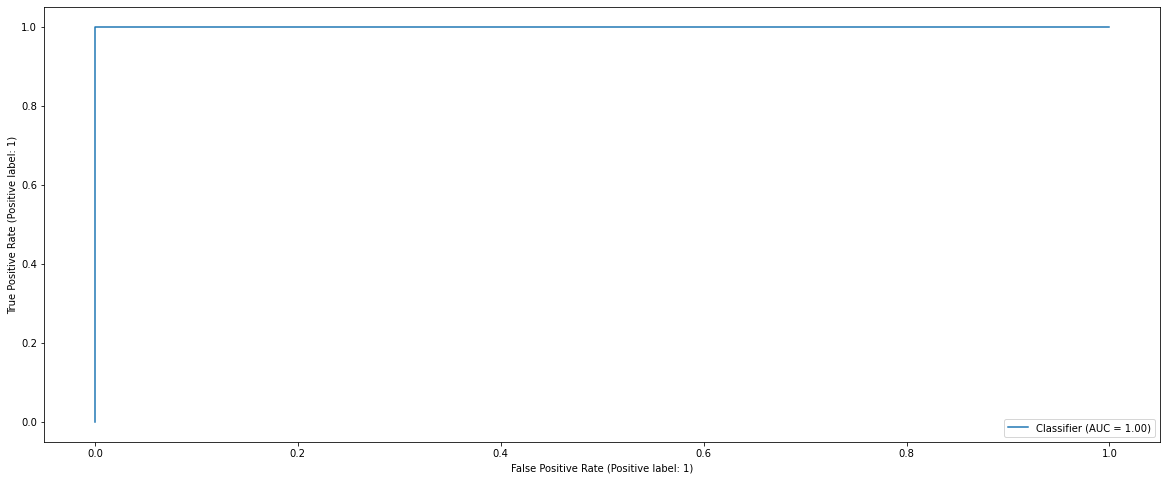

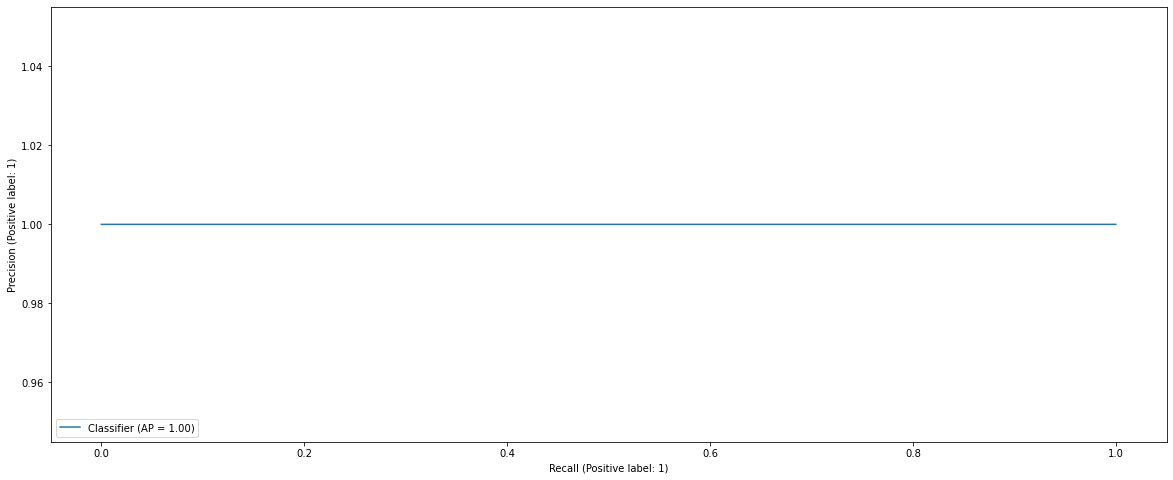

Average Score: 0.9978257023041692
STD Score: 0.007241445891571539


In [73]:
classifier = BSVClassifier(normal_class_label=1, outlier_class_label=-1)
distributions = {'c':uniform(loc=0.2, scale=0.8),'q':uniform(loc=0, scale=3)}

svm_experiment(classifier, distributions, 'roc_auc')
svm_experiment(classifier, distributions, 'average_precision')

### Federated Learning: BSVClassifier

The whole work is inspired by https://arxiv.org/pdf/1602.05629.pdf paper.

Since we are working in an unsupervised setting, our metric is not Accuracy but Roc-Auc.

We will not use E, number of iterations per client update, since we are doing exact calculation and not gradient descent.
Same thing with the parameter B

In [74]:
import sys
import os

PATH_FLOD = "/Users/maxfrax/Desktop/FederatedLearningOutlierDetection"

sys.path.append(os.path.abspath(PATH_FLOD))

from flod.classifiers.federatedbsvclassifier import FederatedBSVClassifier

#### IID

We have about **809 samples**. 
Let's sort them and distribute them among **10 clients**.

There are 9 points that will be randomly left over.

In [75]:
# The data has already been shuffled at the beginning of the file
total_clients = 10

data_per_client = int(len(X)/total_clients)

X = X[0:data_per_client*total_clients]
y = y[0:data_per_client*total_clients]

client_assignment = []

# Split the data among the clients in a balanced way
for i in range(total_clients):
    client_assignment.extend([i]*data_per_client)

print(f'len Client assignment {len(client_assignment)} == len X {len(X)}')

len Client assignment 800 == len X 800


In [76]:
# Inputs
# C: 0 aka 1 client, .1, .2, .5, 1 aka total_clients
# B: 'infinite' aka data_per_client, 1% of data_per_client

parameters = {
'client_fraction': [.1, .5,  1],
'max_rounds': [1, 3, 5],
'B': [1, 5, 10]
}

test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res_iid = search.fit(pd.concat([X,X]).to_numpy(), np.array(y+y), client_assignment=client_assignment+client_assignment)

iid_clf = res_iid.best_estimator_

print(res_iid.best_index_)
print(res_iid.best_score_)
print(res_iid.best_params_)


y_pred = iid_clf.predict(X.to_numpy())

Round 0 of 1
Selected clients [1]
Round 0 of 1
Selected clients [8]
Round 0 of 3
Selected clients [5]
Round 1 of 3
Selected clients [3]
Round 2 of 3
Selected clients [1]
Round 0 of 3
Selected clients [8]
Round 1 of 3
Selected clients [7]
Round 2 of 3
Selected clients [2]
Round 0 of 5
Selected clients [9]
Round 1 of 5
Selected clients [2]
Round 2 of 5
Selected clients [5]
Round 3 of 5
Selected clients [3]
Round 4 of 5
Selected clients [7]
Round 0 of 5
Selected clients [5]
Round 1 of 5
Selected clients [1]
Round 2 of 5
Selected clients [3]
Round 3 of 5
Selected clients [4]
Round 4 of 5
Selected clients [0]
Round 0 of 1
Selected clients [5 2 7 0 3]
Round 0 of 1
Selected clients [1 7 5 8 9]
Round 0 of 3
Selected clients [4 8 5 6 2]
Round 1 of 3
Selected clients [2 6 0 7 3]
Round 2 of 3
Selected clients [5 6 1 8 7]
Round 0 of 3
Selected clients [0 3 5 4 8]
Round 1 of 3
Selected clients [7 1 6 9 0]
Round 2 of 3
Selected clients [2 0 8 6 7]
Round 0 of 5
Selected clients [5 0 6 9 1]
Round 1 of

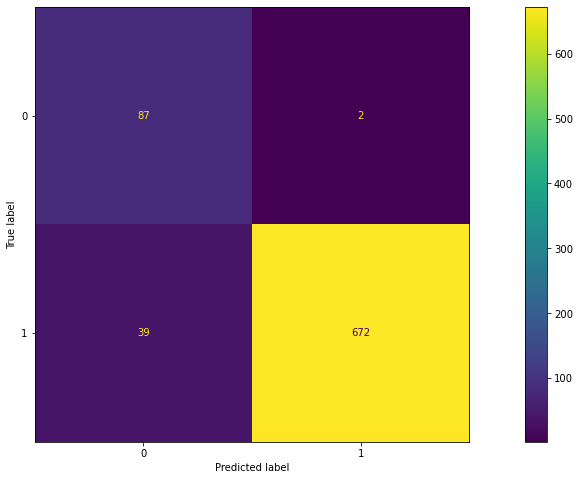

array([[ 87,   2],
       [ 39, 672]])

In [77]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

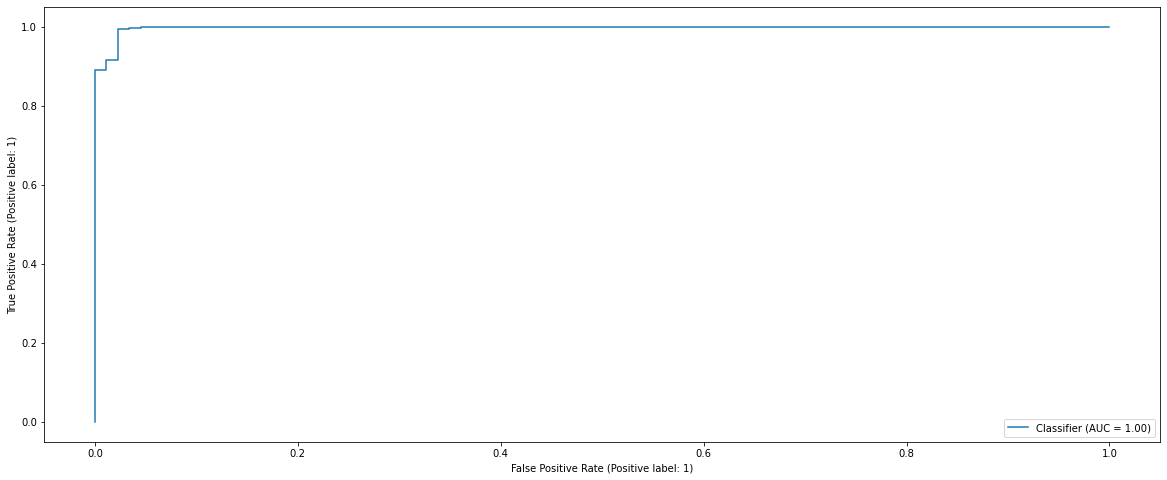

In [78]:
RocCurveDisplay.from_predictions(y, iid_clf.score_samples(X.to_numpy()))

plt.show()

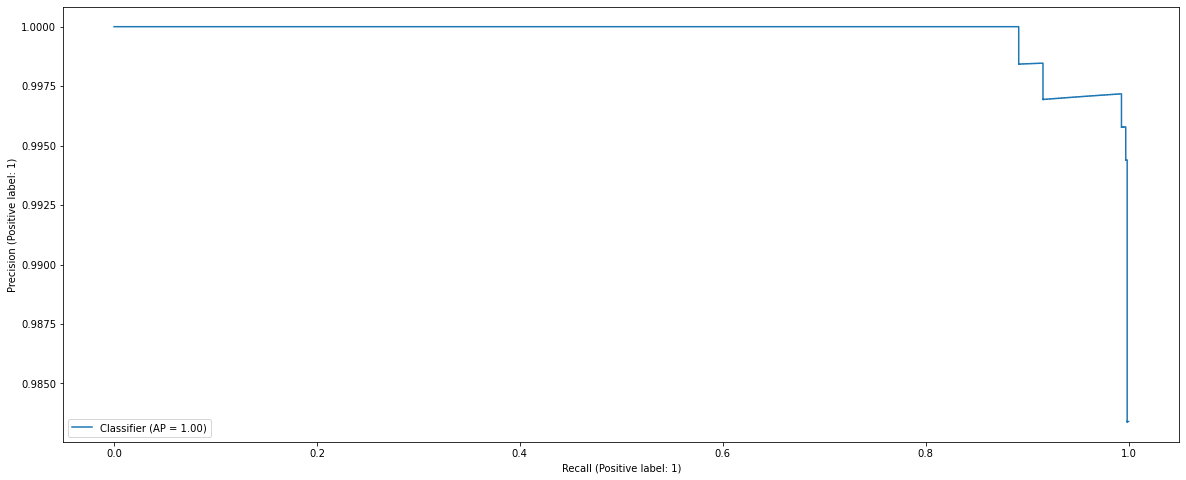

In [79]:
PrecisionRecallDisplay.from_predictions(y, iid_clf.score_samples(X.to_numpy()))

plt.show()

In [80]:
iid_cv_results = pd.DataFrame(res_iid.cv_results_)

iid_cv_results['Datapoints Estimate'] = iid_cv_results['param_B'] * iid_cv_results['param_client_fraction'] * total_clients * iid_cv_results['param_max_rounds']

iid_cv_results = iid_cv_results.sort_values('rank_test_score')

iid_cv_results.to_csv('iid_cv_results.csv')

iid_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,Datapoints Estimate
5,25.989219,1.356979,1.462260,0.094454,1,0.5,5,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 5}",0.999807,0.999586,0.999696,0.000110,1,25.0
6,27.286249,4.289001,3.299741,0.283015,1,1,1,"{'B': 1, 'client_fraction': 1, 'max_rounds': 1}",0.999861,0.999264,0.999562,0.000299,2,10
24,26.732312,2.679888,3.273425,0.208896,10,1,1,"{'B': 10, 'client_fraction': 1, 'max_rounds': 1}",0.999422,0.999629,0.999526,0.000104,3,100
15,25.568763,4.523011,3.207595,0.352496,5,1,1,"{'B': 5, 'client_fraction': 1, 'max_rounds': 1}",0.999852,0.998942,0.999397,0.000455,4,50
2,5.183201,1.629072,0.508512,0.111947,1,0.1,5,"{'B': 1, 'client_fraction': 0.1, 'max_rounds': 5}",0.999422,0.998644,0.999033,0.000389,5,5.0
20,5.323715,1.211377,0.637706,0.123297,10,0.1,5,"{'B': 10, 'client_fraction': 0.1, 'max_rounds'...",0.998358,0.998612,0.998485,0.000127,6,50.0
11,6.499498,1.102017,0.620920,0.123507,5,0.1,5,"{'B': 5, 'client_fraction': 0.1, 'max_rounds': 5}",0.997636,0.998757,0.998197,0.000560,7,25.0
3,6.013019,1.404521,1.433098,0.204770,1,0.5,1,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 1}",0.996199,0.999386,0.997792,0.001594,8,5.0
12,4.813900,0.680746,1.285055,0.110781,5,0.5,1,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 1}",0.998751,0.995270,0.997011,0.001741,9,25.0
7,26.256793,9.258754,0.950835,0.312392,1,1,3,"{'B': 1, 'client_fraction': 1, 'max_rounds': 3}",0.998696,0.993908,0.996302,0.002394,10,30


In [81]:
print(np.average(iid_cv_results['mean_test_score']))
print(np.std(iid_cv_results['mean_test_score']))

0.9905697077284337
0.008004028435068962


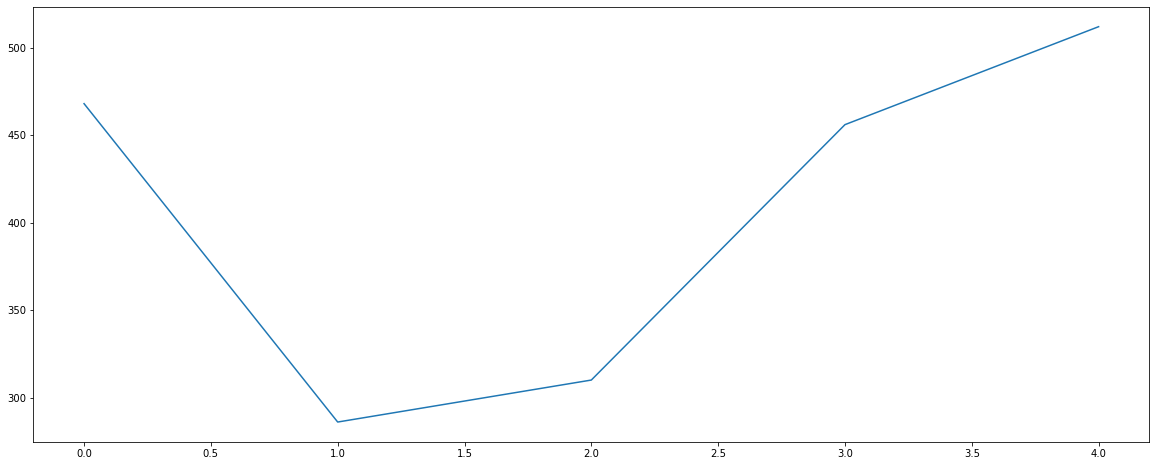

In [82]:
plt.plot(iid_clf.sv_count)
plt.show()

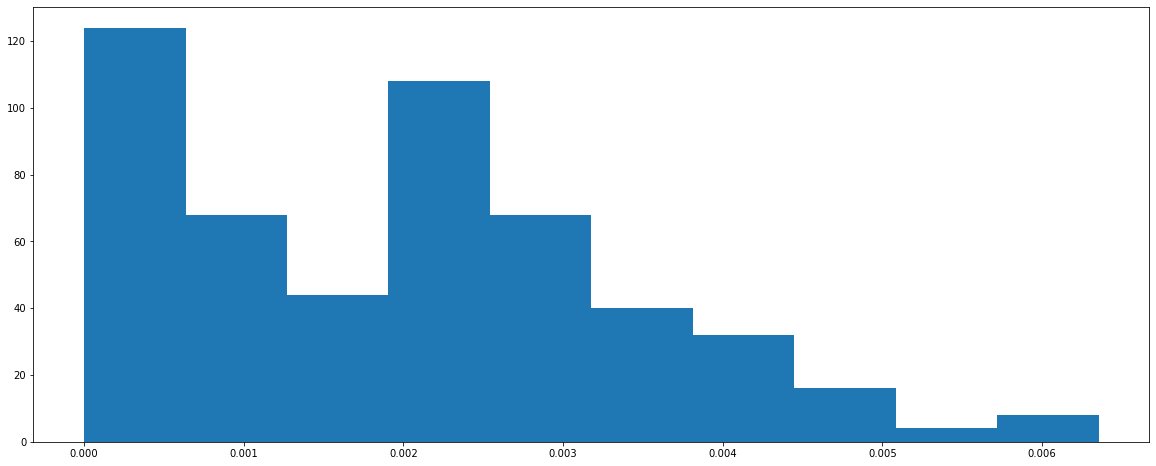

In [83]:
plt.hist(iid_clf.clf.betas_)
plt.show()

In [84]:
display(pd.DataFrame(iid_cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
1,0.994795
5,0.988136
10,0.988778


,mean_test_score
param_B,
1,0.005005
5,0.009401
10,0.008511


,mean_test_score
param_client_fraction,
0.1,0.992202
0.5,0.987705
1.0,0.991802


,mean_test_score
param_client_fraction,
0.1,0.007351
0.5,0.009091
1.0,0.008099


,mean_test_score
param_max_rounds,
1,0.995071
3,0.985514
5,0.991124


,mean_test_score
param_max_rounds,
1,0.004754
3,0.007277
5,0.009422


,param_client_fraction,param_max_rounds,Mean,Std,Scaled Std
6,1.0,1,0.999495,0.000087,0.867005
2,0.1,5,0.998571,0.000425,4.247235
3,0.5,1,0.994192,0.005573,55.725168
0,0.1,1,0.991526,0.003156,31.563879
8,1.0,5,0.990814,0.002998,29.978072
1,0.1,3,0.986509,0.009790,97.904820
7,1.0,3,0.985097,0.009783,97.825264
4,0.5,3,0.984937,0.004249,42.487203
5,0.5,5,0.983986,0.013643,136.429095


<Figure size 1440x576 with 0 Axes>

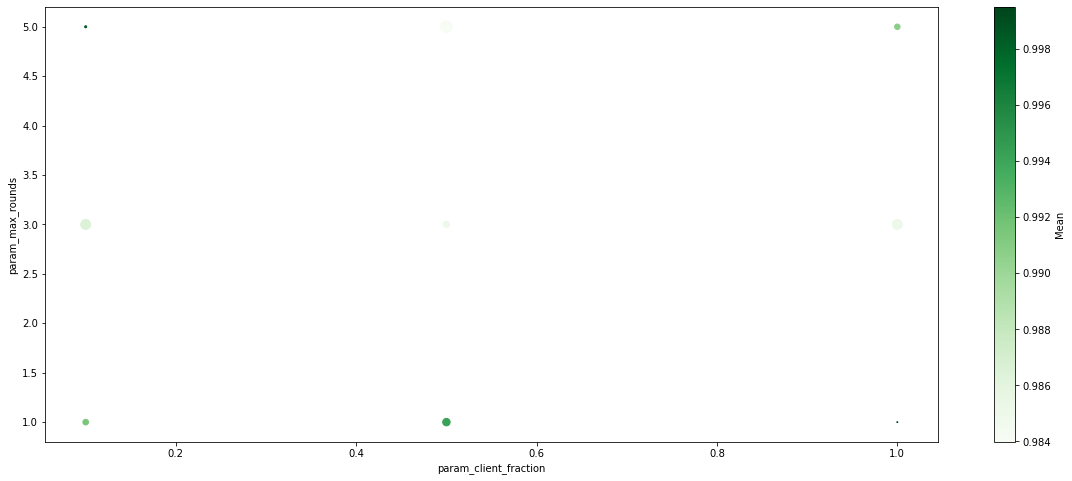

,param_client_fraction,param_B,Mean,Std,Scaled Std
0,0.1,1,0.995069,0.003838,38.383339
3,0.5,1,0.994817,0.006869,68.694595
6,1.0,1,0.994499,0.006167,61.665685
2,0.1,10,0.994223,0.003781,37.813493
8,1.0,10,0.990456,0.010974,109.740042
7,1.0,5,0.990451,0.009357,93.568918
1,0.1,5,0.987314,0.011525,115.252422
4,0.5,5,0.986643,0.010989,109.890089
5,0.5,10,0.981655,0.005495,54.953869


<Figure size 1440x576 with 0 Axes>

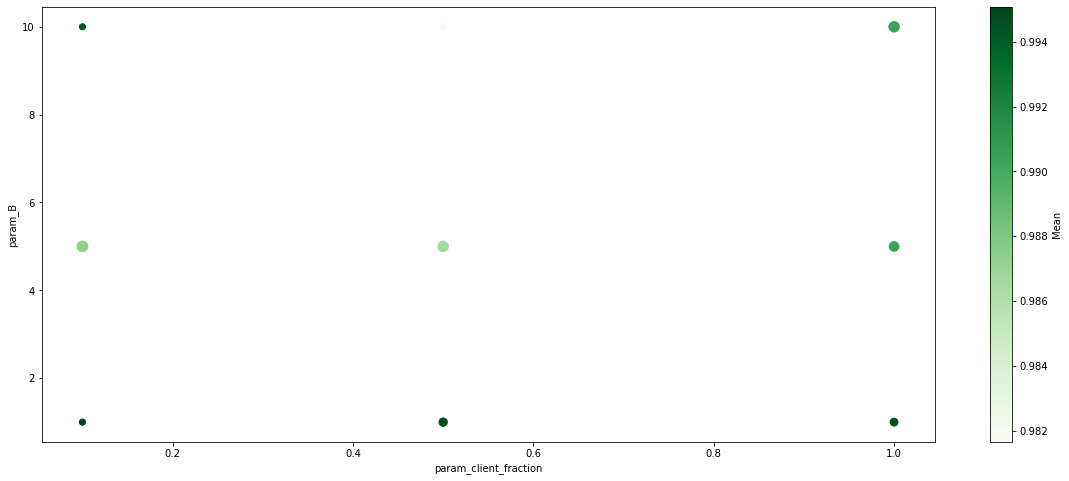

,param_max_rounds,param_B,Mean,Std,Scaled Std
0,1,1,0.997386,0.002405,24.050986
6,5,1,0.995453,0.006782,67.823177
1,1,5,0.994972,0.005724,57.243056
2,1,10,0.992856,0.006035,60.346941
3,3,1,0.991544,0.004673,46.729611
8,5,10,0.989736,0.011182,111.817416
7,5,5,0.988182,0.011834,118.338184
5,3,10,0.983743,0.007996,79.956781
4,3,5,0.981255,0.006295,62.949186


<Figure size 1440x576 with 0 Axes>

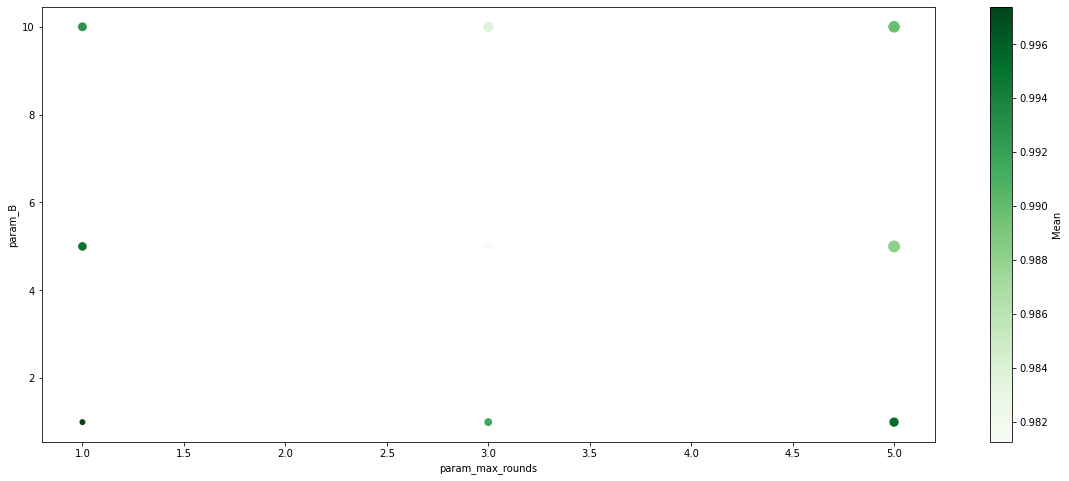

In [85]:
scale_factor = 10000

# Plot 1
plot1_data = pd.DataFrame(iid_cv_results.groupby(['param_client_fraction', 'param_max_rounds']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot1_data.sort_values(by='Mean', ascending=False, inplace=True)
plot1_data['Scaled Std'] = plot1_data['Std'] * scale_factor
display(plot1_data)

fig = plt.figure()
ax1 = plot1_data.plot.scatter(x='param_client_fraction', y='param_max_rounds', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

# Plot 2
plot2_data = pd.DataFrame(iid_cv_results.groupby(['param_client_fraction', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot2_data.sort_values(by='Mean', ascending=False, inplace=True)
plot2_data['Scaled Std'] = plot2_data['Std'] * scale_factor
display(plot2_data)

fig = plt.figure()
ax2 = plot2_data.plot.scatter(x='param_client_fraction', y='param_B', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

# Plot 3
plot3_data = pd.DataFrame(iid_cv_results.groupby(['param_max_rounds', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot3_data.sort_values(by='Mean', ascending=False, inplace=True)
plot3_data['Scaled Std'] = plot3_data['Std'] * scale_factor
display(plot3_data)

fig = plt.figure()
ax3 = plot3_data.plot.scatter(x='param_max_rounds', y='param_B', c='Mean', s='Scaled Std', cmap='Greens', sharex=False)
plt.show()

#### Non IID

In [86]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=total_clients)
client_assignment = list(kmeans.fit_predict(X))

In [87]:
from collections import Counter
Counter(client_assignment)

Counter({3: 52,
         6: 35,
         2: 120,
         5: 126,
         7: 109,
         8: 124,
         9: 51,
         4: 55,
         1: 28,
         0: 100})

In [89]:
parameters = {
'client_fraction': [.1, .5,  1],
'max_rounds': [1, 3, 5],
'B': [1, 5, 10]
}


test_fold = [0 if v < len(X) else 1 for v in range(len(X) * 2)]

search = GridSearchCV(FederatedBSVClassifier(normal_class_label=1, outlier_class_label=-1, total_clients=total_clients), parameters, cv=PredefinedSplit(test_fold=test_fold), refit=True, scoring='average_precision', error_score='raise', verbose=VERBOSE)
res_n_iid = search.fit(pd.concat([X,X]).to_numpy(), np.array(y+y), client_assignment=client_assignment+client_assignment)

n_iid_clf = res_n_iid.best_estimator_

print(res_n_iid.best_index_)
print(res_n_iid.best_score_)
print(res_n_iid.best_params_)


y_pred = n_iid_clf.predict(X.to_numpy())

Round 0 of 1
Selected clients [1]
Client 1 does not have normal class datapoints among the 28 points
No datapoints after combining global model and client update. Is everything okay?
Round 0 of 1
Selected clients [3]
Round 0 of 3
Selected clients [9]
Round 1 of 3
Selected clients [0]
Round 2 of 3
Selected clients [3]
Round 0 of 3
Selected clients [3]
Round 1 of 3
Selected clients [2]
Round 2 of 3
Selected clients [4]
Round 0 of 5
Selected clients [8]
Round 1 of 5
Selected clients [2]
Round 2 of 5
Selected clients [5]
Round 3 of 5
Selected clients [8]
Round 4 of 5
Selected clients [4]
Round 0 of 5
Selected clients [3]
Round 1 of 5
Selected clients [8]
Round 2 of 5
Selected clients [7]
Round 3 of 5
Selected clients [7]
Round 4 of 5
Selected clients [1]
There is no client 1 update. No betas far from zero among all the 0 points
Round 0 of 1
Selected clients [1 6 0 7 4]
Client 1 does not have normal class datapoints among the 28 points
No datapoints after combining global model and client u

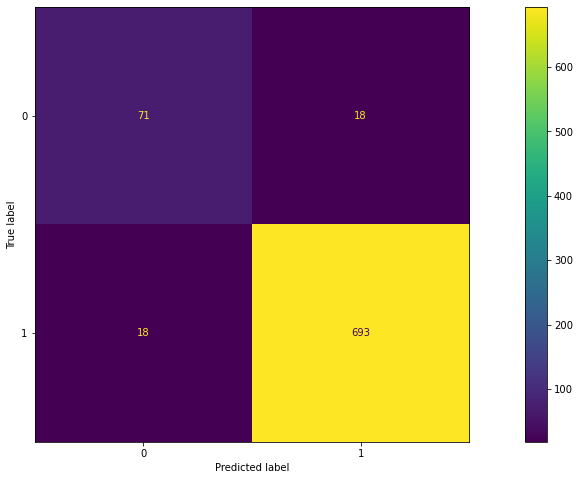

array([[ 71,  18],
       [ 18, 693]])

In [90]:
conf_mat = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.show()

display(conf_mat)

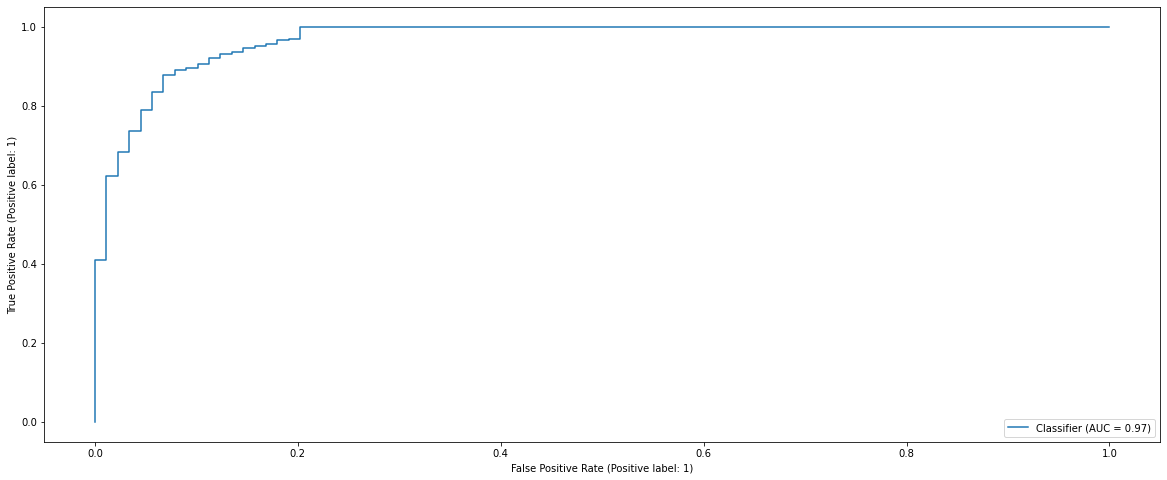

In [91]:
RocCurveDisplay.from_predictions(y, n_iid_clf.score_samples(X.to_numpy()))

plt.show()

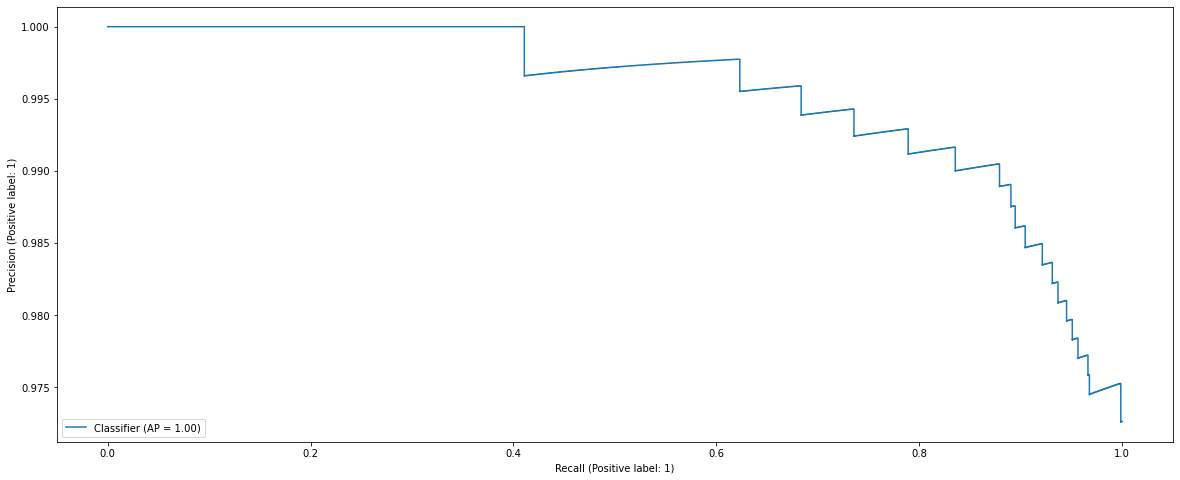

In [92]:
PrecisionRecallDisplay.from_predictions(y, n_iid_clf.score_samples(X.to_numpy()))

plt.show()

In [93]:
n_iid_cv_results = pd.DataFrame(res_n_iid.cv_results_)

n_iid_cv_results['Datapoints Estimate'] = n_iid_cv_results['param_B'] * n_iid_cv_results['param_client_fraction'] * total_clients * n_iid_cv_results['param_max_rounds']

n_iid_cv_results = n_iid_cv_results.sort_values('rank_test_score')

n_iid_cv_results.to_csv('n_iid_cv_results.csv')

n_iid_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_B,param_client_fraction,param_max_rounds,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,Datapoints Estimate
17,24.098471,10.541583,0.900190,0.387557,5,1,5,"{'B': 5, 'client_fraction': 1, 'max_rounds': 5}",0.999837,0.996925,0.998381,0.001456,1,250
23,12.643790,2.462596,0.757586,0.193173,10,0.5,5,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.997541,0.999198,0.998370,0.000829,2,250.0
5,13.704160,2.111718,0.898079,0.333475,1,0.5,5,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 5}",0.997710,0.998694,0.998202,0.000492,3,25.0
8,16.697572,5.389749,0.639989,0.310370,1,1,5,"{'B': 1, 'client_fraction': 1, 'max_rounds': 5}",0.999326,0.992783,0.996054,0.003271,4,50
4,9.071325,5.166714,0.781070,0.491749,1,0.5,3,"{'B': 1, 'client_fraction': 0.5, 'max_rounds': 3}",0.989550,0.999998,0.994774,0.005224,5,15.0
25,9.769546,0.122193,0.567122,0.294334,10,1,3,"{'B': 10, 'client_fraction': 1, 'max_rounds': 3}",0.988152,0.998081,0.993117,0.004965,6,300
26,31.725257,11.307709,1.424739,0.406487,10,1,5,"{'B': 10, 'client_fraction': 1, 'max_rounds': 5}",0.999857,0.986321,0.993089,0.006768,7,500
22,5.500309,1.602117,0.483086,0.291247,10,0.5,3,"{'B': 10, 'client_fraction': 0.5, 'max_rounds'...",0.999012,0.985890,0.992451,0.006561,8,150.0
13,4.355466,0.593496,0.536418,0.235055,5,0.5,3,"{'B': 5, 'client_fraction': 0.5, 'max_rounds': 3}",0.992435,0.986482,0.989458,0.002977,9,75.0
16,5.955348,0.986130,0.383170,0.167963,5,1,3,"{'B': 5, 'client_fraction': 1, 'max_rounds': 3}",0.991145,0.985207,0.988176,0.002969,10,150


In [94]:
print(np.average(n_iid_cv_results['mean_test_score']))
print(np.std(n_iid_cv_results['mean_test_score']))

0.966207830470949
0.0316088006355774


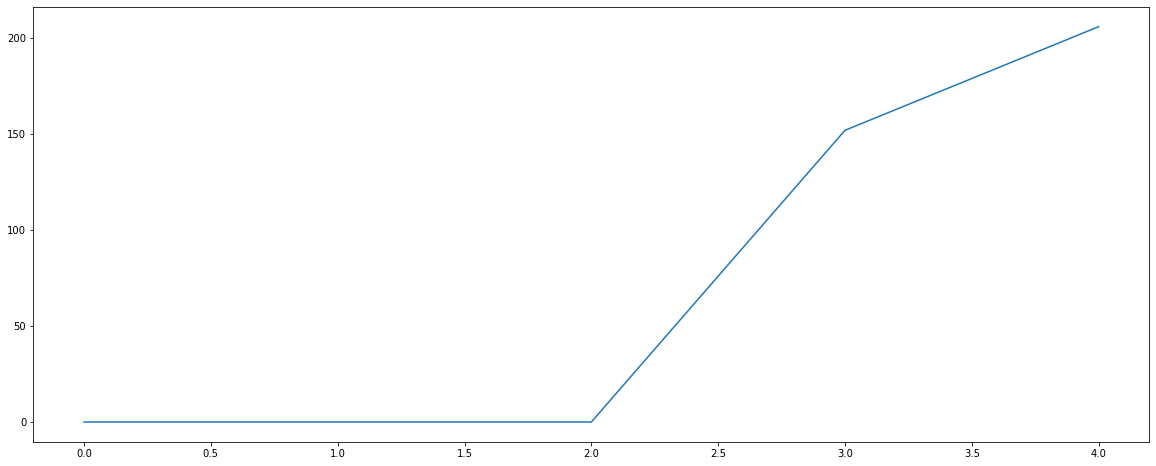

In [95]:
plt.plot(n_iid_clf.sv_count)
plt.show()

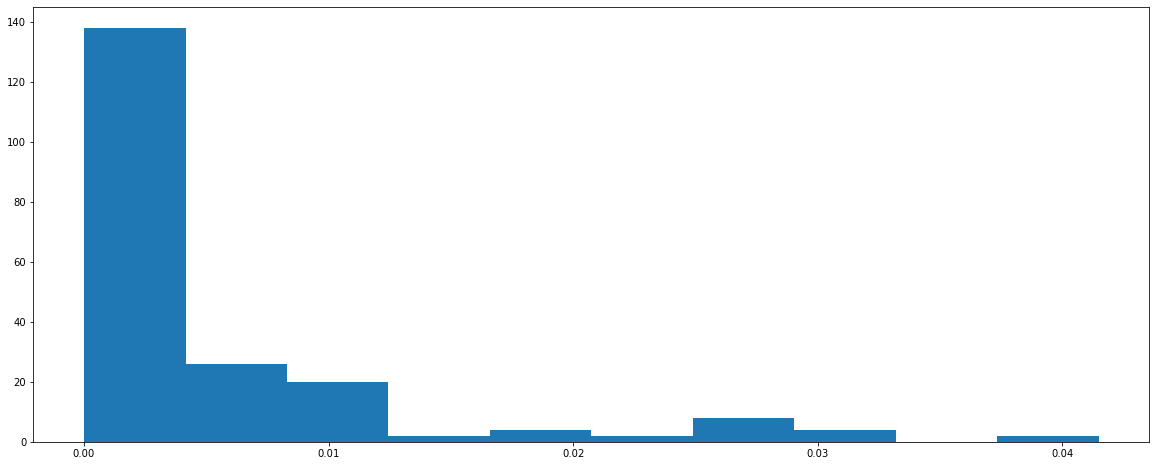

In [96]:
plt.hist(n_iid_clf.clf.betas_)
plt.show()

In [97]:
display(pd.DataFrame(n_iid_cv_results.groupby(['param_B'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_B'])['mean_test_score'].std()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction'])['mean_test_score'].std()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].mean()))
display(pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds'])['mean_test_score'].std()))

,mean_test_score
param_B,
1,0.961795
5,0.963894
10,0.972935


,mean_test_score
param_B,
1,0.040696
5,0.031916
10,0.024867


,mean_test_score
param_client_fraction,
0.1,0.947253
0.5,0.971711
1.0,0.979659


,mean_test_score
param_client_fraction,
0.1,0.032703
0.5,0.033264
1.0,0.023543


,mean_test_score
param_max_rounds,
1,0.937383
3,0.979866
5,0.981374


,mean_test_score
param_max_rounds,
1,0.034170
3,0.016781
5,0.022792


,param_client_fraction,param_max_rounds,Mean,Std,Scaled Std
8,1.0,5,0.995842,0.002652,26.523115
5,0.5,5,0.994348,0.006821,68.206010
4,0.5,3,0.992228,0.002665,26.647890
7,1.0,3,0.983226,0.013088,130.876744
1,0.1,3,0.964143,0.018194,181.943679
6,1.0,1,0.959910,0.032278,322.783958
2,0.1,5,0.953933,0.018123,181.226733
3,0.5,1,0.928556,0.013365,133.652125
0,0.1,1,0.923684,0.047857,478.571290


<Figure size 1440x576 with 0 Axes>

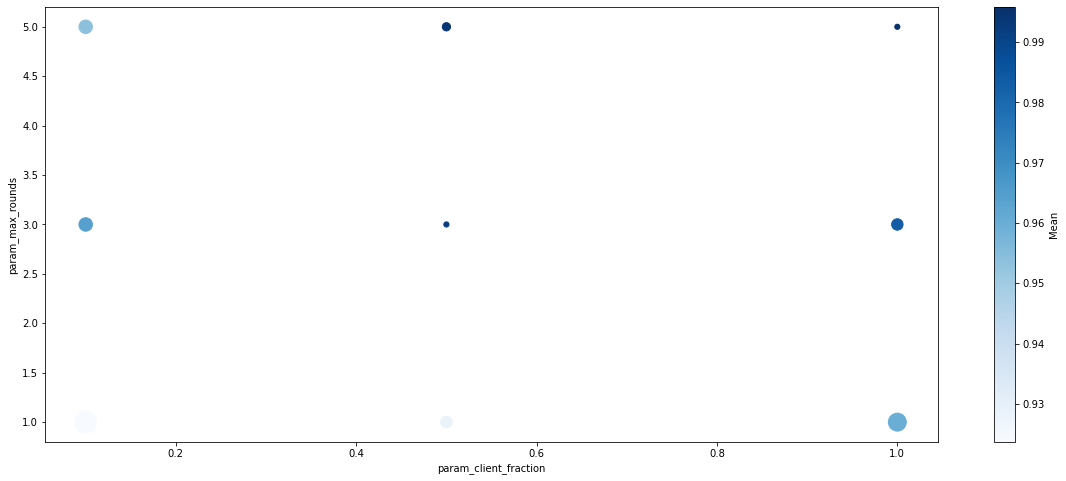

,param_client_fraction,param_B,Mean,Std,Scaled Std
8,1.0,10,0.990672,0.004210,42.096619
6,1.0,1,0.978203,0.015485,154.850175
3,0.5,1,0.977747,0.032505,325.048885
5,0.5,10,0.974076,0.037071,370.710645
7,1.0,5,0.970102,0.040466,404.658415
4,0.5,5,0.963309,0.042733,427.327636
1,0.1,5,0.958272,0.022477,224.768624
2,0.1,10,0.954056,0.008545,85.446228
0,0.1,1,0.929433,0.054514,545.143968


<Figure size 1440x576 with 0 Axes>

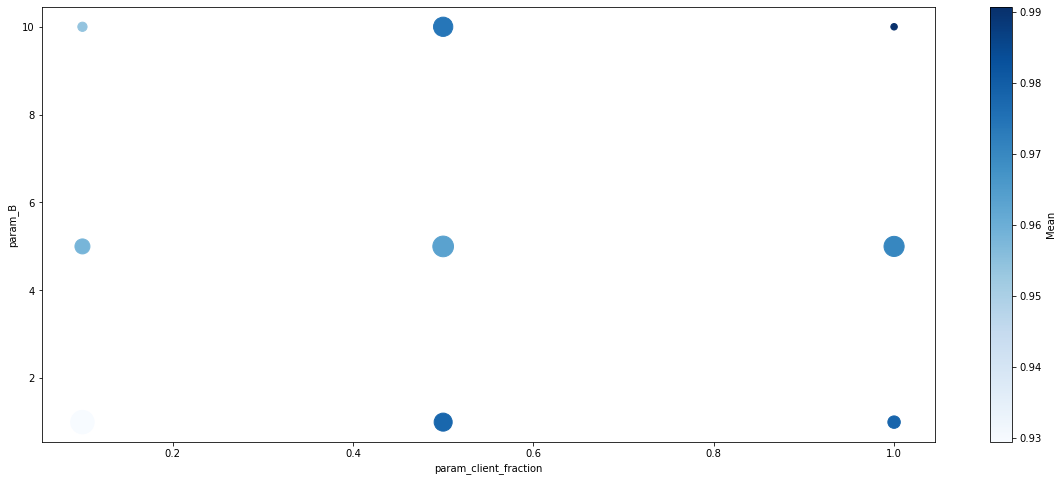

,param_max_rounds,param_B,Mean,Std,Scaled Std
6,5,1,0.989311,0.013582,135.823099
4,3,5,0.986703,0.003717,37.174648
5,3,10,0.983144,0.016700,166.995989
8,5,10,0.980509,0.026494,264.937873
7,5,5,0.974303,0.031952,319.517069
3,3,1,0.969749,0.024371,243.709941
2,1,10,0.955150,0.027855,278.545259
1,1,5,0.930677,0.021019,210.191908
0,1,1,0.926324,0.052233,522.332862


<Figure size 1440x576 with 0 Axes>

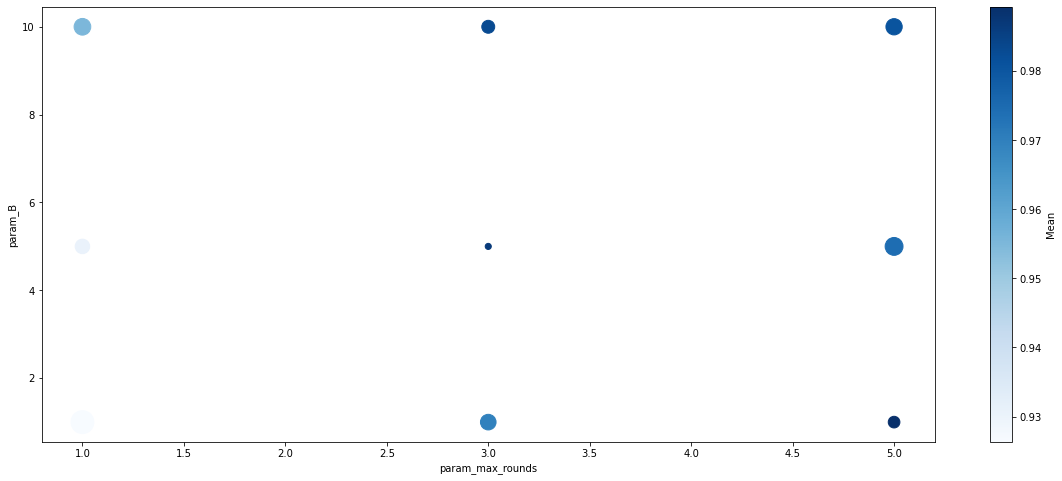

In [98]:
scale_factor = 10000

# Plot 1
plot1_data = pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction', 'param_max_rounds']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot1_data.sort_values(by='Mean', ascending=False, inplace=True)
plot1_data['Scaled Std'] = plot1_data['Std'] * scale_factor
display(plot1_data)

fig = plt.figure()
ax1 = plot1_data.plot.scatter(x='param_client_fraction', y='param_max_rounds', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()

# Plot 2
plot2_data = pd.DataFrame(n_iid_cv_results.groupby(['param_client_fraction', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot2_data.sort_values(by='Mean', ascending=False, inplace=True)
plot2_data['Scaled Std'] = plot2_data['Std'] * scale_factor
display(plot2_data)

fig = plt.figure()
ax2 = plot2_data.plot.scatter(x='param_client_fraction', y='param_B', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()

# Plot 3
plot3_data = pd.DataFrame(n_iid_cv_results.groupby(['param_max_rounds', 'param_B']).agg(Mean=('mean_test_score', 'mean'), Std=('mean_test_score', 'std'))).reset_index()
plot3_data.sort_values(by='Mean', ascending=False, inplace=True)
plot3_data['Scaled Std'] = plot3_data['Std'] * scale_factor
display(plot3_data)

fig = plt.figure()
ax3 = plot3_data.plot.scatter(x='param_max_rounds', y='param_B', c='Mean', s='Scaled Std', cmap='Blues', sharex=False)
plt.show()